# Preprocessing

In [1]:
import pandas
import konlpy
import gensim
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from konlpy.tag import Mecab
from collections import Counter

In [2]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


# Tokenization

In [3]:
# tokenizing Korean
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)} # word to index dict
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [4]:
# index to word dict
index_to_word = {index:word for word, index in word_to_index.items()}

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [6]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [7]:
# change both types from list to ndarray
X_train = np.array(get_encoded_sentences(X_train, word_to_index), dtype='object')
X_test = np.array(get_encoded_sentences(X_test, word_to_index), dtype='object')

In [8]:
# add padding upto the length of the longest sentence
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)

# Text classification

### RNN

In [9]:
# vocab_size = len(word_to_index)  # 위 예시에서 딕셔너리에 포함된 단어 개수는 10
# word_vector_dim = 4    # 그림과 같이 4차원의 워드 벡터를 가정합니다.

# embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, mask_zero=True)

# # tf.keras.preprocessing.sequence.pad_sequences를 통해 word vector를 모두 일정 길이로 맞춰주어야 
# # embedding 레이어의 input이 될 수 있음에 주의해 주세요. 
# raw_inputs = np.array(get_encoded_sentences(sentences, word_to_index), dtype=object)
# raw_inputs = tf.keras.preprocessing.sequence.pad_sequences(raw_inputs,
#                                                        value=word_to_index['<PAD>'],
#                                                        padding='pre',
#                                                        maxlen=max_len)
# output = embedding(raw_inputs)
# print(output)

In [10]:
vocab_size = 10  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(16))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 4)           40        
_________________________________________________________________
lstm (LSTM)                  (None, 16)                1344      
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,529
Trainable params: 1,529
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(X_test, y_test),
                    verbose=1)

Epoch 1/20
286/286 [==============================] - 5s 8ms/step - loss: 0.6931 - accuracy: 0.5023 - val_loss: 0.6928 - val_accuracy: 0.5105
Epoch 2/20
286/286 [==============================] - 2s 6ms/step - loss: 0.6929 - accuracy: 0.5060 - val_loss: 0.6928 - val_accuracy: 0.5105
Epoch 3/20
286/286 [==============================] - 2s 6ms/step - loss: 0.6928 - accuracy: 0.5061 - val_loss: 0.6927 - val_accuracy: 0.5104
Epoch 4/20
286/286 [==============================] - 2s 6ms/step - loss: 0.6928 - accuracy: 0.5074 - val_loss: 0.6927 - val_accuracy: 0.5105
Epoch 5/20
286/286 [==============================] - 2s 6ms/step - loss: 0.6928 - accuracy: 0.5051 - val_loss: 0.6927 - val_accuracy: 0.5102
Epoch 6/20
286/286 [==============================] - 2s 6ms/step - loss: 0.6928 - accuracy: 0.5054 - val_loss: 0.6927 - val_accuracy: 0.5103
Epoch 7/20
286/286 [==============================] - 2s 6ms/step - loss: 0.6928 - accuracy: 0.5068 - val_loss: 0.6928 - val_accuracy: 0.5096
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


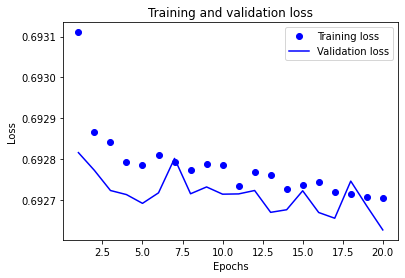

In [12]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

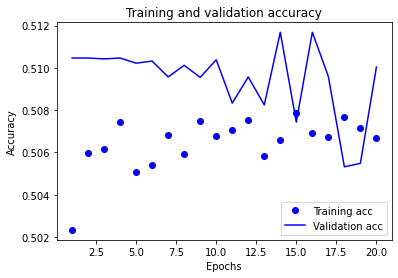

In [13]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 1-D CNN

In [14]:
vocab_size = 10  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 4)           40        
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          464       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [15]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(X_test, y_test),
                    verbose=1)

Epoch 1/20
286/286 [==============================] - 3s 6ms/step - loss: 0.6929 - accuracy: 0.5055 - val_loss: 0.6928 - val_accuracy: 0.5095
Epoch 2/20
286/286 [==============================] - 1s 5ms/step - loss: 0.6928 - accuracy: 0.5071 - val_loss: 0.6928 - val_accuracy: 0.5095
Epoch 3/20
286/286 [==============================] - 1s 5ms/step - loss: 0.6928 - accuracy: 0.5076 - val_loss: 0.6927 - val_accuracy: 0.5095
Epoch 4/20
286/286 [==============================] - 1s 5ms/step - loss: 0.6928 - accuracy: 0.5072 - val_loss: 0.6928 - val_accuracy: 0.5104
Epoch 5/20
286/286 [==============================] - 1s 5ms/step - loss: 0.6928 - accuracy: 0.5082 - val_loss: 0.6927 - val_accuracy: 0.5095
Epoch 6/20
286/286 [==============================] - 1s 5ms/step - loss: 0.6927 - accuracy: 0.5092 - val_loss: 0.6929 - val_accuracy: 0.5023
Epoch 7/20
286/286 [==============================] - 1s 5ms/step - loss: 0.6927 - accuracy: 0.5086 - val_loss: 0.6927 - val_accuracy: 0.5105
Epoch 

### GlobalMaxPooling1D

In [16]:
vocab_size = 10  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 4)           40        
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 4)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(X_test, y_test),
                    verbose=1)

Epoch 1/20
286/286 [==============================] - 2s 4ms/step - loss: 0.6931 - accuracy: 0.5038 - val_loss: 0.6930 - val_accuracy: 0.4973
Epoch 2/20
286/286 [==============================] - 1s 4ms/step - loss: 0.6929 - accuracy: 0.5013 - val_loss: 0.6927 - val_accuracy: 0.5101
Epoch 3/20
286/286 [==============================] - 1s 4ms/step - loss: 0.6928 - accuracy: 0.5047 - val_loss: 0.6927 - val_accuracy: 0.5101
Epoch 4/20
286/286 [==============================] - 1s 4ms/step - loss: 0.6927 - accuracy: 0.5035 - val_loss: 0.6927 - val_accuracy: 0.5101
Epoch 5/20
286/286 [==============================] - 1s 4ms/step - loss: 0.6928 - accuracy: 0.5040 - val_loss: 0.6927 - val_accuracy: 0.5101
Epoch 6/20
286/286 [==============================] - 1s 4ms/step - loss: 0.6927 - accuracy: 0.5064 - val_loss: 0.6927 - val_accuracy: 0.5101
Epoch 7/20
286/286 [==============================] - 1s 4ms/step - loss: 0.6927 - accuracy: 0.5025 - val_loss: 0.6927 - val_accuracy: 0.5101
Epoch 

# 회고

1회차
- 이번 프로젝트를 진행하며 3가지 방식으로 모델을 구축하였다.
    - RNN, 1-D CNN, 그리고 Globalmaxpooling 1D
- 처음에는 데이터 전처리 흐름이 잘 이해하기 힘들어서 여러번 노드를 보며 진행하였다.
- 시각화를 해본 결과, loss가 0.6 이하로 내려가지 않았고 accuracy도 50% 이상으로 올라가지 않았다